In [2]:
import FX_DATA_GEN as DG
from THEO_POULA_Model import LSTMModel, get_model

import pandas as pd
import numpy as np
from numpy import hstack, array
from torch.utils.data import TensorDataset, DataLoader
import torch 
from torch import nn
import torch.nn.functional as F
from datetime import datetime
from THEO_POULA_Optim import THEOPOULA
from torch.utils.tensorboard import SummaryWriter
import os
import matplotlib.pyplot as plt
import pickle as pkl

In [ ]:
#daily FX Rate dataset call
#DG.Get_curr_data('MX')

In [ ]:
#Macro economic dataset call
#MEX = DG.MacEcon_TS('MX',1980, 2020)

In [ ]:
#Description of Macro economic dataset
#DG.describe_MacEcon_TS(MEX)

## Create dataset & Clean

In [3]:
#Joint dataset of Macro economic & FX Rates combined
mex_full = DG.Get_FX_MacEcon_Data('MX')
mex_full.head()

MXN    Yr  DoM  MoY   sin_DoY   cos_DoY  \
Date                                                       
1994-03-22  3.148060  1994   22    3  0.981306  0.192452   
1994-03-23  3.150121  1994   23    3  0.984474  0.175531   
1994-03-25  3.151439  1994   25    3  0.989932  0.141540   
1994-03-28  3.152770  1994   28    3  0.995919  0.090252   
1994-03-29  3.153992  1994   29    3  0.997325  0.073095   

            Ave Monthly USD FX Rate  Inflation (CPI) %  \
Date                                                     
1994-03-22                   3.2841          19.200372   
1994-03-23                   3.2841          19.200372   
1994-03-25                   3.2841          19.200372   
1994-03-28                   3.2841          19.200372   
1994-03-29                   3.2841          19.200372   

            Deposit Interest Rate %  Lending Interest Rate %  ...  \
Date                                                          ...   
1994-03-22                    10.16                    13.46  ...   
1994-03-23                    10.16                    13.46  ...   
1994-03-25                    10.16                    13.46  ...   
1994-03-28                    10.16                    13.46  ...   
1994-03-29                    10.16                    13.46  ...   

            Umemployment rate(%)  Current Account(%GDP)  FDI(%GDP)  \
Date                                                                 
1994-03-22                   NaN              -1.284829   0.597181   
1994-03-23                   NaN              -1.284829   0.597181   
1994-03-25                   NaN              -1.284829   0.597181   
1994-03-28                   NaN              -1.284829   0.597181   
1994-03-29                   NaN              -1.284829   0.597181   

            Total Debt(USD)  Short Term Debt(USD)  Capital Formations(USD)  \
Date                                                                         
1994-03-22              NaN                   NaN             1.143940e+11   
1994-03-23              NaN                   NaN             1.143940e+11   
1994-03-25              NaN                   NaN             1.143940e+11   
1994-03-28              NaN                   NaN             1.143940e+11   
1994-03-29              NaN                   NaN             1.143940e+11   

            Gov Consumption Expendature (%GDP)  GDP % Growth  MXN_30_ave  \
Date                                                                       
1994-03-22                            9.466826      5.407474    3.210477   
1994-03-23                            9.466826      5.407474    3.218217   
1994-03-25                            9.466826      5.407474    3.226637   
1994-03-28                            9.466826      5.407474    3.235130   
1994-03-29                            9.466826      5.407474    3.243263   

            MXN_60_ave  
Date                    
1994-03-22    3.158837  
1994-03-23    3.162712  
1994-03-25    3.166922  
1994-03-28    3.171152  
1994-03-29    3.175152  

[5 rows x 31 columns]

In [6]:
#Description to know which columns to remove from dataframe
DG.describe_MacEcon_TS(mex_full)

Features First Valid Last Valid  Null Values
0                                  MXN  1994-03-22 2020-11-30            0
1                                   Yr  1994-03-22 2020-11-30            0
2                                  DoM  1994-03-22 2020-11-30            0
3                                  MoY  1994-03-22 2020-11-30            0
4                              sin_DoY  1994-03-22 2020-11-30            0
5                              cos_DoY  1994-03-22 2020-11-30            0
6              Ave Monthly USD FX Rate  1994-03-22 2020-11-30            0
7                    Inflation (CPI) %  1994-03-22 2020-11-30            0
8              Deposit Interest Rate %  1994-03-22 2020-11-30            0
9              Lending Interest Rate %  1994-03-22 2020-11-30            0
10                        Exports(USD)  1994-03-22 2020-11-30            0
11                       Imports (USD)  1994-03-22 2019-01-31          458
12                      NY.GDP.MKTP.CD  1994-03-22 2020-11-30            0
13               Real Interest Rate(%)  1994-03-22 2020-11-30            0
14        Foreign Exchange Reserves(%)  1994-03-22 2020-11-30            0
15            M2 Multiplier Growth (%)  1994-03-22 2020-11-30            0
16                         M2/Reserves  1994-03-22 2009-08-31         2814
17                  REED 12mth std dev  1994-03-22 2020-11-30            0
18              Domestic Credit to GDP  1994-03-22 2009-08-31         2814
19                      Trade Openness  1994-03-22 2019-01-31          458
20          Portfolio Investments(USD)  2009-01-02 2020-11-30         3717
21                Umemployment rate(%)  2000-04-03 2020-11-30         1515
22               Current Account(%GDP)  1994-03-22 2020-11-30            0
23                           FDI(%GDP)  1994-03-22 2020-11-30            0
24                     Total Debt(USD)  2008-01-02 2020-11-30         3465
25                Short Term Debt(USD)  2008-01-02 2020-11-30         3465
26             Capital Formations(USD)  1994-03-22 2020-11-30            0
27  Gov Consumption Expendature (%GDP)  1994-03-22 2020-11-30            0
28                        GDP % Growth  1994-03-22 2020-11-30            0
29                          MXN_30_ave  1994-03-22 2020-11-30            0
30                          MXN_60_ave  1994-03-22 2020-11-30            0

In [4]:
MEX_copy = mex_full.copy()

In [5]:
#Add one hot dummy columns for month
MEX_copy = (DG.Add_dummy_MoY(MEX_copy))
MEX_copy.head()

MXN    Yr  DoM   sin_DoY   cos_DoY  Ave Monthly USD FX Rate  \
Date                                                                           
1994-03-22  3.148060  1994   22  0.981306  0.192452                   3.2841   
1994-03-23  3.150121  1994   23  0.984474  0.175531                   3.2841   
1994-03-25  3.151439  1994   25  0.989932  0.141540                   3.2841   
1994-03-28  3.152770  1994   28  0.995919  0.090252                   3.2841   
1994-03-29  3.153992  1994   29  0.997325  0.073095                   3.2841   

            Inflation (CPI) %  Deposit Interest Rate %  \
Date                                                     
1994-03-22          19.200372                    10.16   
1994-03-23          19.200372                    10.16   
1994-03-25          19.200372                    10.16   
1994-03-28          19.200372                    10.16   
1994-03-29          19.200372                    10.16   

            Lending Interest Rate %  Exports(USD)  ...  MoY_is_3  MoY_is_4  \
Date                                               ...                       
1994-03-22                    13.46  5.155500e+09  ...         1         0   
1994-03-23                    13.46  5.155500e+09  ...         1         0   
1994-03-25                    13.46  5.155500e+09  ...         1         0   
1994-03-28                    13.46  5.155500e+09  ...         1         0   
1994-03-29                    13.46  5.155500e+09  ...         1         0   

            MoY_is_5  MoY_is_6  MoY_is_7  MoY_is_8  MoY_is_9  MoY_is_10  \
Date                                                                      
1994-03-22         0         0         0         0         0          0   
1994-03-23         0         0         0         0         0          0   
1994-03-25         0         0         0         0         0          0   
1994-03-28         0         0         0         0         0          0   
1994-03-29         0         0         0         0         0          0   

            MoY_is_11  MoY_is_12  
Date                              
1994-03-22          0          0  
1994-03-23          0          0  
1994-03-25          0          0  
1994-03-28          0          0  
1994-03-29          0          0  

[5 rows x 42 columns]

In [7]:
#Description of cleaned and one-hott'ed dataset
MEX_copy.drop(columns = ['M2/Reserves',# Nan Values
                        'Domestic Credit to GDP', # Nan Values
                        'Portfolio Investments(USD)',# Nan Values
                        'Total Debt(USD)', # Nan Values
                        'Short Term Debt(USD)', # Nan Values
                        'Umemployment rate(%)', # Nan Values
                        'cos_DoY',
                        'Yr',
                        'DoM',
                        'M2 Multiplier Growth (%)' # Data flatlines in 2008
                        ], inplace = True)
#Fields with the same end date
MEX_copy.dropna(axis=0, subset = ['Imports (USD)',
                        'Trade Openness'], inplace = True)
DG.describe_MacEcon_TS(MEX_copy)

Features First Valid Last Valid  Null Values
0                                  MXN  1994-03-22 2019-01-31            0
1                              sin_DoY  1994-03-22 2019-01-31            0
2              Ave Monthly USD FX Rate  1994-03-22 2019-01-31            0
3                    Inflation (CPI) %  1994-03-22 2019-01-31            0
4              Deposit Interest Rate %  1994-03-22 2019-01-31            0
5              Lending Interest Rate %  1994-03-22 2019-01-31            0
6                         Exports(USD)  1994-03-22 2019-01-31            0
7                        Imports (USD)  1994-03-22 2019-01-31            0
8                       NY.GDP.MKTP.CD  1994-03-22 2019-01-31            0
9                Real Interest Rate(%)  1994-03-22 2019-01-31            0
10        Foreign Exchange Reserves(%)  1994-03-22 2019-01-31            0
11            M2 Multiplier Growth (%)  1994-03-22 2019-01-31            0
12                  REED 12mth std dev  1994-03-22 2019-01-31            0
13                      Trade Openness  1994-03-22 2019-01-31            0
14               Current Account(%GDP)  1994-03-22 2019-01-31            0
15                           FDI(%GDP)  1994-03-22 2019-01-31            0
16             Capital Formations(USD)  1994-03-22 2019-01-31            0
17  Gov Consumption Expendature (%GDP)  1994-03-22 2019-01-31            0
18                        GDP % Growth  1994-03-22 2019-01-31            0
19                          MXN_30_ave  1994-03-22 2019-01-31            0
20                          MXN_60_ave  1994-03-22 2019-01-31            0
21                            MoY_is_1  1994-03-22 2019-01-31            0
22                            MoY_is_2  1994-03-22 2019-01-31            0
23                            MoY_is_3  1994-03-22 2019-01-31            0
24                            MoY_is_4  1994-03-22 2019-01-31            0
25                            MoY_is_5  1994-03-22 2019-01-31            0
26                            MoY_is_6  1994-03-22 2019-01-31            0
27                            MoY_is_7  1994-03-22 2019-01-31            0
28                            MoY_is_8  1994-03-22 2019-01-31            0
29                            MoY_is_9  1994-03-22 2019-01-31            0
30                           MoY_is_10  1994-03-22 2019-01-31            0
31                           MoY_is_11  1994-03-22 2019-01-31            0
32                           MoY_is_12  1994-03-22 2019-01-31            0

In [8]:
# Shift DF so that there is a FX_X and FX_Y at the start & end of the DF, respectively. 
MEX_SHF = DG.shift_FX(MEX_copy)
MEX_SHF.head(10)

MXN_X   sin_DoY  Ave Monthly USD FX Rate  Inflation (CPI) %  \
Date                                                                         
1994-03-23  3.148060  0.984474                   3.2841          19.200372   
1994-03-25  3.150121  0.989932                   3.2841          19.200372   
1994-03-28  3.151439  0.995919                   3.2841          19.200372   
1994-03-29  3.152770  0.997325                   3.2841          19.200372   
1994-03-30  3.153992  0.998435                   3.2841          19.200372   
1994-03-31  3.155614  0.999250                   3.2841          19.200372   
1994-04-04  3.158470  0.999546                   3.3536          19.294411   
1994-04-05  3.161221  0.998880                   3.3536          19.294411   
1994-04-06  3.164119  0.997917                   3.3536          19.294411   
1994-04-07  3.167012  0.996659                   3.3536          19.294411   

            Deposit Interest Rate %  Lending Interest Rate %  Exports(USD)  \
Date                                                                         
1994-03-23                    10.16                    13.46  5.155500e+09   
1994-03-25                    10.16                    13.46  5.155500e+09   
1994-03-28                    10.16                    13.46  5.155500e+09   
1994-03-29                    10.16                    13.46  5.155500e+09   
1994-03-30                    10.16                    13.46  5.155500e+09   
1994-03-31                    10.16                    13.46  5.155500e+09   
1994-04-04                    15.60                    20.58  4.655100e+09   
1994-04-05                    15.60                    20.58  4.655100e+09   
1994-04-06                    15.60                    20.58  4.655100e+09   
1994-04-07                    15.60                    20.58  4.655100e+09   

            Imports (USD)  NY.GDP.MKTP.CD  Real Interest Rate(%)  ...  \
Date                                                              ...   
1994-03-23   6.790318e+09    5.278132e+11              -5.740372  ...   
1994-03-25   6.790318e+09    5.278132e+11              -5.740372  ...   
1994-03-28   6.790318e+09    5.278132e+11              -5.740372  ...   
1994-03-29   6.790318e+09    5.278132e+11              -5.740372  ...   
1994-03-30   6.790318e+09    5.278132e+11              -5.740372  ...   
1994-03-31   6.790318e+09    5.278132e+11              -5.740372  ...   
1994-04-04   6.359792e+09    5.278132e+11               1.285589  ...   
1994-04-05   6.359792e+09    5.278132e+11               1.285589  ...   
1994-04-06   6.359792e+09    5.278132e+11               1.285589  ...   
1994-04-07   6.359792e+09    5.278132e+11               1.285589  ...   

            MoY_is_4  MoY_is_5  MoY_is_6  MoY_is_7  MoY_is_8  MoY_is_9  \
Date                                                                     
1994-03-23         0         0         0         0         0         0   
1994-03-25         0         0         0         0         0         0   
1994-03-28         0         0         0         0         0         0   
1994-03-29         0         0         0         0         0         0   
1994-03-30         0         0         0         0         0         0   
1994-03-31         0         0         0         0         0         0   
1994-04-04         1         0         0         0         0         0   
1994-04-05         1         0         0         0         0         0   
1994-04-06         1         0         0         0         0         0   
1994-04-07         1         0         0         0         0         0   

            MoY_is_10  MoY_is_11  MoY_is_12     MXN_Y  
Date                                                   
1994-03-23          0          0          0  3.150121  
1994-03-25          0          0          0  3.151439  
1994-03-28          0          0          0  3.152770  
1994-03-29          0          0          0  3.153992  
1994-03-30          0          0       

In [ ]:
MEX_FX_ONLY = MEX_SHF[['MXN_X','MXN_30_ave','MXN_60_ave','MXN_Y']]

## Normalise & pre-process data for pytorch (3D array)

<ipython-input-54-06e3be1c0d4b>:8: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  fig.tight_layout()


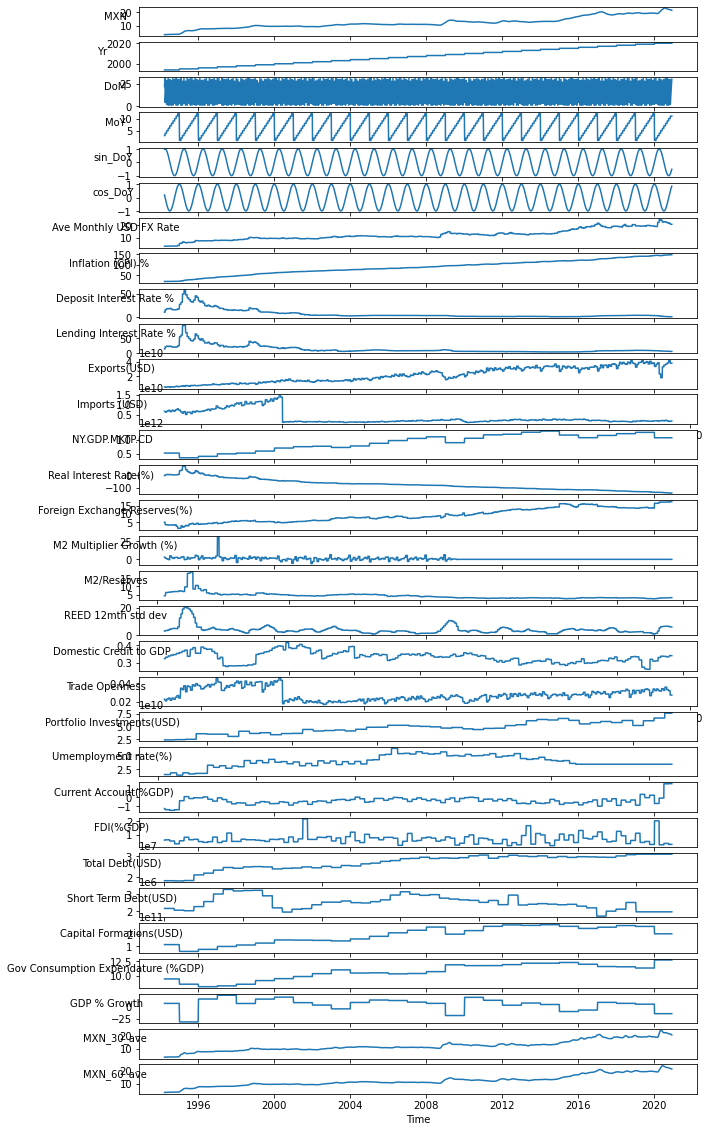

In [54]:
cols = mex_full.columns
fig, ax = plt.subplots(nrows = len(cols), ncols = 1, figsize=(10,20))
for i in range(len(cols)):
    ax[i].plot(mex_full.index, mex_full[cols[i]], label=cols[i])
    ax[i].set_xlabel('Time')
    ax[i].set_ylabel(cols[i], rotation=0)
    #ax[i].legend()
fig.tight_layout()        

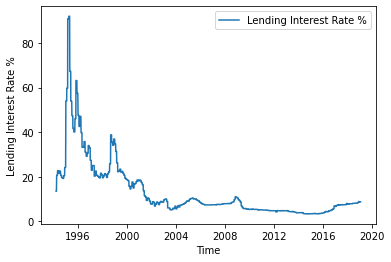

In [48]:
X = MEX_SHF['Lending Interest Rate %']
plt.figure(1)
plt.plot(MEX_SHF.index, X , label=X.name)
plt.xlabel('Time')
plt.ylabel(X.name)
plt.legend()

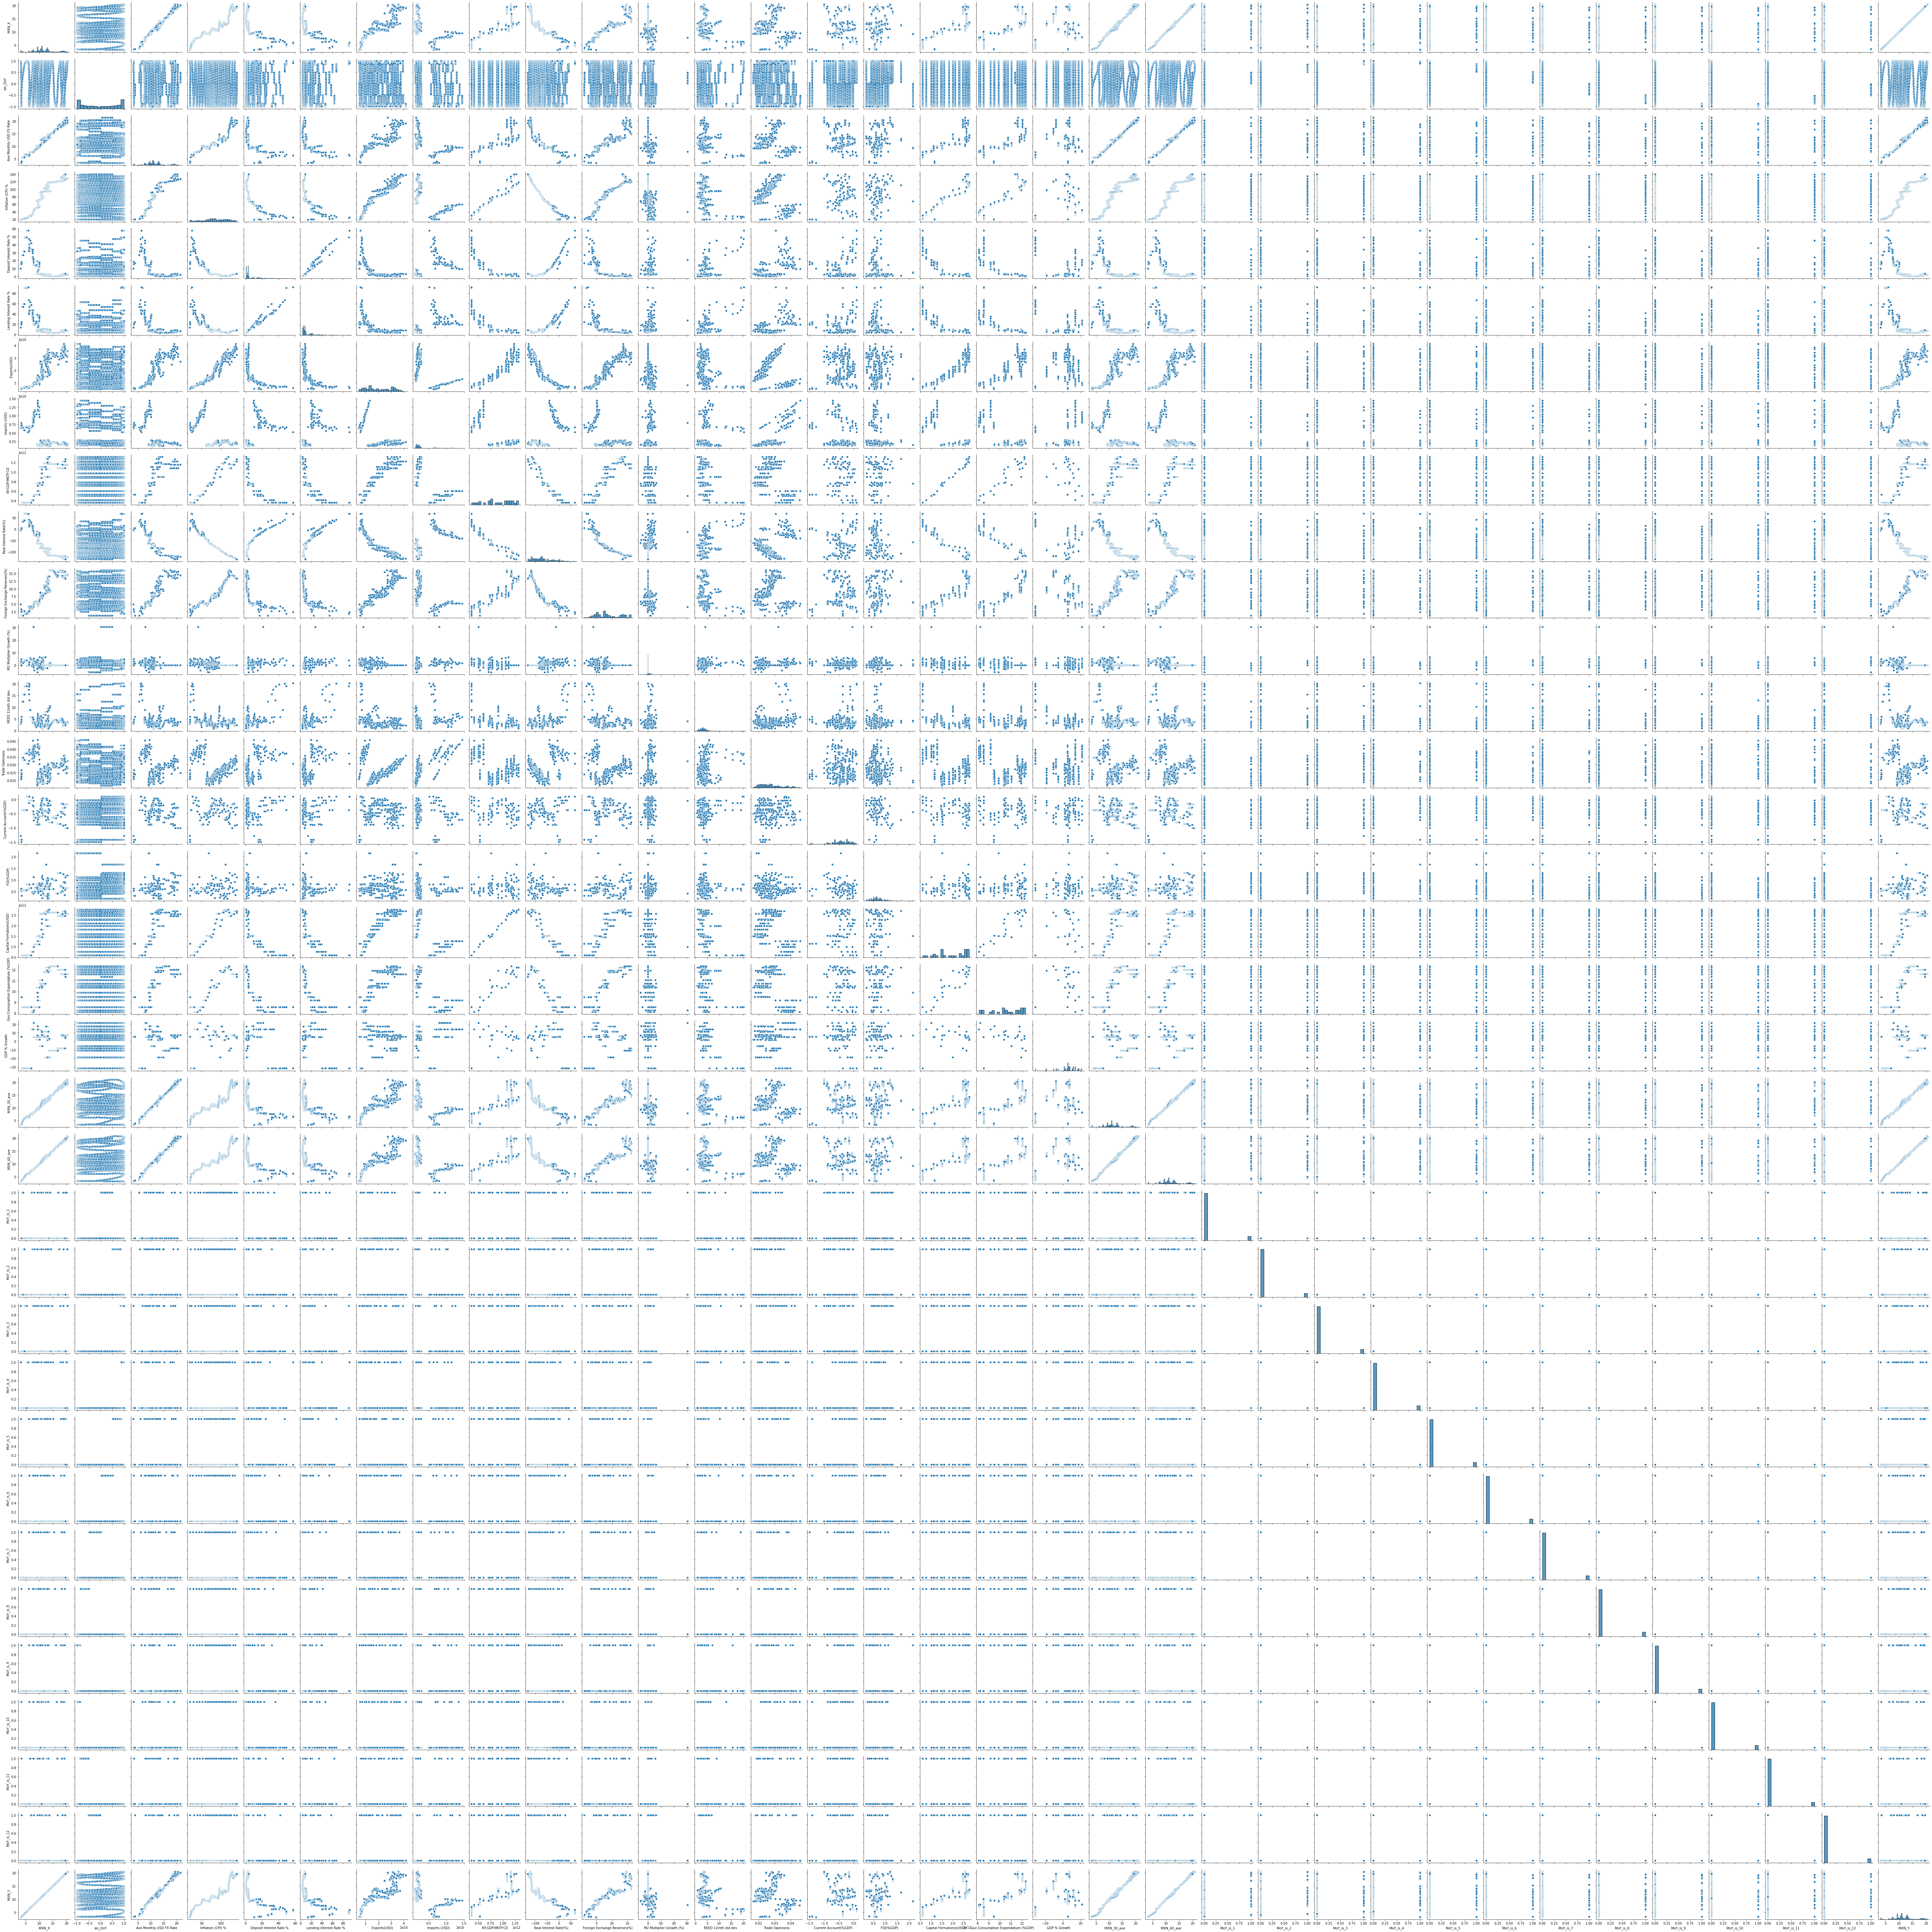

In [44]:
import seaborn as sns
sns.pairplot(MEX_SHF)

In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


#Set split param
test_ratio = 0.25
val_ratio = test_ratio / (1 - test_ratio)

#Cut into Features and Target Variable
y_name = MEX_SHF.iloc[:,-1].name
X, y = MEX_SHF.drop([y_name], axis=1) , MEX_SHF[[y_name]]

#Train & Test 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio, shuffle=False)
#Train & Validation 
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_ratio, shuffle=False)

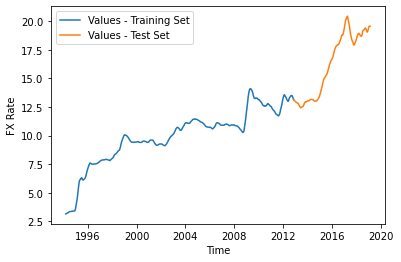

In [10]:
plt.figure(1)
plt.plot(X_train.index, X_train.iloc[:,0], label='Values - Training Set')
#plt.plot(X_val.index, X_val.iloc[:,0], label='Values - Validation Set')
plt.plot(X_test.index, X_test.iloc[:,0], label='Values - Test Set')

plt.xlabel('Time')
plt.ylabel('FX Rate')
plt.legend()

In [11]:
#Normalise data using standard scalar
#Fit each row of data as an array
#from sklearn.preprocessing import MinMaxScaler
scaler = DG.get_scaler('minmax')#DG.get_scaler('standard')


X_train_arr = scaler.fit_transform(X_train)
#X_val_arr = scaler.transform(X_val)
X_test_arr = scaler.transform(X_test)

y_train_arr = y_train #scaler.fit_transform(y_train)
#y_val_arr = y_val #scaler.transform(y_val)
y_test_arr =y_test #scaler.transform(y_test)

#Stack the data back together before splitting the sequence
train_arr = hstack((X_train_arr, y_train_arr))
#val_arr = hstack((X_val_arr, y_val_arr))
test_arr = hstack((X_test_arr, y_test_arr))

#split sequence will create a lag of the past 300 entries of the dataframe
#
n_steps = 90
X_train_split, y_train_split = DG.split_sequences(train_arr,n_steps)
#X_val_split, y_val_split = DG.split_sequences(val_arr,n_steps)
X_test_split, y_test_split = DG.split_sequences(test_arr,n_steps)

In [23]:
batch_size = 32

train_features = torch.Tensor(X_train_split)
train_targets = torch.Tensor(y_train_split)
#val_features = torch.Tensor(X_val_split)
#val_targets = torch.Tensor(y_val_split)
test_features = torch.Tensor(X_test_split)
test_targets = torch.Tensor(y_test_split)

#Joint Tensor of 
train = TensorDataset(train_features, train_targets)
#val = TensorDataset(val_features, val_targets)
test = TensorDataset(test_features, test_targets)

train_loader = DataLoader(train, batch_size=batch_size, shuffle=False, drop_last=True)
#val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader_one = DataLoader(test, batch_size=1, shuffle=False, drop_last=True)

In [ ]:
#Specify Optimizer
#optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [ ]:
#opt = Optimization(model=model, loss_fn=loss_fn, optimizer=optimizer)
#opt.train(train_loader, val_loader, batch_size=batch_size, n_epochs=n_epochs, n_features=input_dim)
#opt.plot_losses()

#predictions, values = opt.evaluate(test_loader_one, batch_size=1, n_features=input_dim)

## Set Hyper parameters

In [33]:
import argparse
import time

import torch.optim as optim

input_dim = len(X_train.columns) #sequence length
output_dim = 1
seq_length = n_steps
hidden_dim = 10
layer_dim = 1
batch_size = batch_size
dropout = 0.2
#n_epochs = 100
#learning_rate = 1e-3
weight_decay = 1e-6

model_params = {'input_dim': input_dim,
                'hidden_dim' : hidden_dim,
                'seq_length' : seq_length,
                'layer_dim' : layer_dim,
                'output_dim' : output_dim,
                'dropout_prob' : dropout}

#Call the LSTM Model from THEO_PULA_Model
#model = get_model("lstm", model_params)
loss_fn = nn.MSELoss(reduction="mean")



parser = argparse.ArgumentParser(description = 'pytorch CIFAR10')
parser.add_argument('-f','--file',help='Path for input file. First line should contain number of lines to search in')
parser.add_argument('--trial', default='trial1', type=str)
parser.add_argument('--lr', default=1e-2, type=float, help='learning rate')
parser.add_argument('--resume', '-r', action='store_true', help='resume from checkpoint')
parser.add_argument('--batch_size', default=64, type=int)
parser.add_argument('--model_name', default='lstm', type=str)
parser.add_argument('--num_epoch', default=400, type=int, dest='num_epoch')
parser.add_argument('--optimizer_name', default='THEOPOULA', type=str)
parser.add_argument('--eta', default='0', type=float)
parser.add_argument('--beta', default='1e14', type=float)
parser.add_argument('--r', default=5, type=int)
parser.add_argument('--eps', default=1e-4, type=float)
parser.add_argument('--act_fn', default='silu', type=str)

parser.add_argument('--log_dir', default='./log/', type=str)
parser.add_argument('--ckpt_dir', default='./ckpt/', type=str)

args = parser.parse_args()

device = 'cuda' if torch.cuda.is_available() else 'cpu'

start_time = time.time()

best_loss = 999
state = []
start_epoch = 1
trial = args.trial
#batch_size = args.batch_size
num_epoch = args.num_epoch  #________________________________Change for real batch______________________ 20
optimizer_name = args.optimizer_name
act_fn = args.act_fn
model_name = args.model_name
model = get_model(args.model_name, model_params)
lr = args.lr
eta = args.eta
beta = args.beta
r = args.r
eps = args.eps
print("Model:",model)

Model: LSTMModel(
  (lstm): LSTM(33, 10, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=10, out_features=1, bias=True)
)


C:\Users\S1026623\Anaconda3\lib\site-packages\torch\nn\modules\rnn.py:60: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [34]:
#Len of a dataloader is the number of batches: len(dataloader) = dataset size / batch size
num_data = len(train_loader)
print('num_data:',num_data)
num_batch = np.ceil(num_data / batch_size)
print('num_batch:',num_batch)

num_data: 143
num_batch: 5.0


In [35]:
print('==> Building model.. on {%s}'%device)
net = model
net.to(device)
criterion = nn.MSELoss(reduction='mean')

==> Building model.. on {cpu}


In [36]:
net

LSTMModel(
  (lstm): LSTM(33, 10, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=10, out_features=1, bias=True)
)

In [38]:
# To specfy when calling 
optimizer_name = 'ADAM'
#_______________________________________________
print('==> Setting optimizer.. {%s}'%optimizer_name)
if optimizer_name == 'SGD':
    optimizer = optim.SGD(net.parameters(), lr=lr)
elif optimizer_name == 'RMSProp':
    optimizer = optim.RMSprop(net.parameters(), lr=lr)
elif optimizer_name == 'ADAM':
    optimizer = optim.Adam(net.parameters(), lr=lr)
elif optimizer_name == 'AMSGrad':
    optimizer = optim.Adam(net.parameters(), lr=lr, amsgrad=True)
elif optimizer_name == 'THEOPOULA':
    optimizer = THEOPOULA(net.parameters(), lr=lr, eta=eta, beta=args.beta, r=r, eps=eps)



if optimizer_name == 'THEOPOULA':
    experiment_name = '%s_%s_bs{%d}_lr{%.1e}_epoch{%d}_eta{%.1e}_beta{%.1e}_r{%d}_eps{%.1e}' \
                      %(optimizer_name, model, batch_size, lr, num_epoch, eta, beta, r, eps)
else:
    experiment_name = '%s_%s_bs{%d}_lr{%.1e}_eps{%.1e}_epoch{%d}'%(optimizer_name, model_name, batch_size, lr, eps, num_epoch)
    


log_dir = args.log_dir + experiment_name
ckpt_dir = args.ckpt_dir + experiment_name

fn_pred = lambda output: torch.softmax(output, dim=1)
#fn_acc = lambda pred, label: ((pred.max(dim=1)[1] == label).type(torch.float)).mean()
#fn_acc = lambda pred, label: (np.absolute(pred.detach().numpy()-label.detach().numpy())).mean()
fn_acc = lambda pred, label: torch.sqrt(criterion(pred, label))

writer = SummaryWriter(log_dir=log_dir)

## Training

history = {'training_loss': [],
           'test_loss': [],
           'training_acc': [],
           'test_acc': [],
           }

print('Saving to:', experiment_name)

==> Setting optimizer.. {ADAM}
Saving to: ADAM_lstm_bs{32}_lr{1.0e-02}_eps{1.0e-04}_epoch{400}


## Trian & Test Model

In [39]:
def train(epoch):
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = []
    acc_arr = []
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        #inputs = inputs.to(device)
        inputs = inputs.view([batch_size, -1, input_dim]).to(device)
        targets = targets.to(device)
        optimizer.zero_grad()        

        outputs = net(inputs)
        #pred = fn_pred(outputs)
        pred = torch.flatten(outputs)
        loss = criterion(outputs, targets)
        acc = fn_acc(pred, targets)

        loss.backward()
        optimizer.step()
        train_loss += [loss.item()]
        acc_arr += [acc.item()]

        if batch_idx%25 == 0:
            print('TRAIN: EPOCH %04d/%04d | BATCH %04d/%04d | LOSS: %.4f |  ACC %.4f' %
              (epoch, args.num_epoch, batch_idx, num_batch, train_loss[-1], acc_arr[-1]))
    print('TRAIN: EPOCH %04d/%04d | LOSS: %.4f |  ACC %.4f' %
          (epoch, args.num_epoch, np.mean(train_loss), np.mean(acc_arr)))
    writer.add_scalar('Training loss', np.mean(train_loss), epoch)
    writer.add_scalar('Training accuracy', np.mean(acc_arr), epoch)

    history['training_loss'].append(np.mean(train_loss))
    history['training_acc'].append(np.mean(acc_arr))


def test(epoch):
    global best_loss, state
    net.eval()
    test_loss = []
    acc_arr = []

    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(test_loader):
            inputs = inputs.view([batch_size, -1, input_dim]).to(device)
            targets = targets.to(device)
            outputs = net(inputs)
            #pred = fn_pred(outputs)
            pred = torch.flatten(outputs)
            loss = criterion(outputs, targets)
            acc = fn_acc(pred, targets)

            test_loss += [loss.item()]
            acc_arr += [acc.item()]

        print('TEST:  LOSS: %.4f |  ACC %.4f' %
                  (np.mean(test_loss),  np.mean(acc_arr)))

    if np.mean(test_loss) < best_loss:
        print('Saving..')
        state = {
            'net': net.state_dict(),
            'acc': np.mean(test_loss),
            'epoch': epoch,
            'optim': optimizer.state_dict()
        }
        best_loss = np.mean(test_loss)

    writer.add_scalar('Test loss', np.mean(test_loss), epoch)
    writer.add_scalar('Test accuracy', np.mean(acc_arr), epoch)

    history['test_loss'].append(np.mean(test_loss))
    history['test_acc'].append(np.mean(acc_arr))


Epoch: 1
TRAIN: EPOCH 0001/0400 | BATCH 0000/0005 | LOSS: 13.0970 |  ACC 3.6189


C:\Users\S1026623\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


TRAIN: EPOCH 0001/0400 | BATCH 0025/0005 | LOSS: 26.1704 |  ACC 5.1156
TRAIN: EPOCH 0001/0400 | BATCH 0050/0005 | LOSS: 10.2299 |  ACC 3.1984
TRAIN: EPOCH 0001/0400 | BATCH 0075/0005 | LOSS: 6.6458 |  ACC 2.5779
TRAIN: EPOCH 0001/0400 | BATCH 0100/0005 | LOSS: 0.6103 |  ACC 0.7812
TRAIN: EPOCH 0001/0400 | BATCH 0125/0005 | LOSS: 1.6920 |  ACC 1.3008
TRAIN: EPOCH 0001/0400 | LOSS: 11.8416 |  ACC 2.8667
TEST:  LOSS: 25.1959 |  ACC 4.2379
Saving..

Epoch: 2
TRAIN: EPOCH 0002/0400 | BATCH 0000/0005 | LOSS: 76.7827 |  ACC 8.7626
TRAIN: EPOCH 0002/0400 | BATCH 0025/0005 | LOSS: 2.8541 |  ACC 1.6894
TRAIN: EPOCH 0002/0400 | BATCH 0050/0005 | LOSS: 0.4511 |  ACC 0.6716
TRAIN: EPOCH 0002/0400 | BATCH 0075/0005 | LOSS: 2.9324 |  ACC 1.7124
TRAIN: EPOCH 0002/0400 | BATCH 0100/0005 | LOSS: 0.1989 |  ACC 0.4460
TRAIN: EPOCH 0002/0400 | BATCH 0125/0005 | LOSS: 1.3560 |  ACC 1.1645
TRAIN: EPOCH 0002/0400 | LOSS: 5.5688 |  ACC 1.5800
TEST:  LOSS: 24.3170 |  ACC 4.1331
Saving..

Epoch: 3
TRAIN: EPOCH 0

TRAIN: EPOCH 0016/0400 | LOSS: 0.2300 |  ACC 0.3605
TEST:  LOSS: 16.2940 |  ACC 3.1977
Saving..

Epoch: 17
TRAIN: EPOCH 0017/0400 | BATCH 0000/0005 | LOSS: 0.0062 |  ACC 0.0793
TRAIN: EPOCH 0017/0400 | BATCH 0025/0005 | LOSS: 0.0067 |  ACC 0.0658
TRAIN: EPOCH 0017/0400 | BATCH 0050/0005 | LOSS: 0.0871 |  ACC 0.2770
TRAIN: EPOCH 0017/0400 | BATCH 0075/0005 | LOSS: 0.6675 |  ACC 0.8170
TRAIN: EPOCH 0017/0400 | BATCH 0100/0005 | LOSS: 0.0198 |  ACC 0.1395
TRAIN: EPOCH 0017/0400 | BATCH 0125/0005 | LOSS: 0.0329 |  ACC 0.1815
TRAIN: EPOCH 0017/0400 | LOSS: 0.2107 |  ACC 0.3447
TEST:  LOSS: 15.5488 |  ACC 3.1191
Saving..

Epoch: 18
TRAIN: EPOCH 0018/0400 | BATCH 0000/0005 | LOSS: 0.0022 |  ACC 0.0484
TRAIN: EPOCH 0018/0400 | BATCH 0025/0005 | LOSS: 0.0046 |  ACC 0.0485
TRAIN: EPOCH 0018/0400 | BATCH 0050/0005 | LOSS: 0.0713 |  ACC 0.2458
TRAIN: EPOCH 0018/0400 | BATCH 0075/0005 | LOSS: 0.6305 |  ACC 0.7939
TRAIN: EPOCH 0018/0400 | BATCH 0100/0005 | LOSS: 0.0180 |  ACC 0.1325
TRAIN: EPOCH 001

TRAIN: EPOCH 0032/0400 | BATCH 0100/0005 | LOSS: 0.1778 |  ACC 0.4207
TRAIN: EPOCH 0032/0400 | BATCH 0125/0005 | LOSS: 0.0704 |  ACC 0.2661
TRAIN: EPOCH 0032/0400 | LOSS: 0.1702 |  ACC 0.3363
TEST:  LOSS: 12.4088 |  ACC 2.7437

Epoch: 33
TRAIN: EPOCH 0033/0400 | BATCH 0000/0005 | LOSS: 0.0003 |  ACC 0.0198
TRAIN: EPOCH 0033/0400 | BATCH 0025/0005 | LOSS: 0.0991 |  ACC 0.3114
TRAIN: EPOCH 0033/0400 | BATCH 0050/0005 | LOSS: 0.2443 |  ACC 0.4692
TRAIN: EPOCH 0033/0400 | BATCH 0075/0005 | LOSS: 0.8595 |  ACC 0.9270
TRAIN: EPOCH 0033/0400 | BATCH 0100/0005 | LOSS: 0.1735 |  ACC 0.4155
TRAIN: EPOCH 0033/0400 | BATCH 0125/0005 | LOSS: 0.0673 |  ACC 0.2601
TRAIN: EPOCH 0033/0400 | LOSS: 0.1752 |  ACC 0.3444
TEST:  LOSS: 12.5314 |  ACC 2.7582

Epoch: 34
TRAIN: EPOCH 0034/0400 | BATCH 0000/0005 | LOSS: 0.0017 |  ACC 0.0409
TRAIN: EPOCH 0034/0400 | BATCH 0025/0005 | LOSS: 0.0711 |  ACC 0.2628
TRAIN: EPOCH 0034/0400 | BATCH 0050/0005 | LOSS: 0.2642 |  ACC 0.4892
TRAIN: EPOCH 0034/0400 | BATCH 007

TRAIN: EPOCH 0048/0400 | BATCH 0075/0005 | LOSS: 0.7175 |  ACC 0.8469
TRAIN: EPOCH 0048/0400 | BATCH 0100/0005 | LOSS: 0.1738 |  ACC 0.4160
TRAIN: EPOCH 0048/0400 | BATCH 0125/0005 | LOSS: 0.0162 |  ACC 0.1279
TRAIN: EPOCH 0048/0400 | LOSS: 0.1017 |  ACC 0.2468
TEST:  LOSS: 12.4479 |  ACC 2.7622

Epoch: 49
TRAIN: EPOCH 0049/0400 | BATCH 0000/0005 | LOSS: 0.0010 |  ACC 0.0325
TRAIN: EPOCH 0049/0400 | BATCH 0025/0005 | LOSS: 0.0208 |  ACC 0.1380
TRAIN: EPOCH 0049/0400 | BATCH 0050/0005 | LOSS: 0.1016 |  ACC 0.2827
TRAIN: EPOCH 0049/0400 | BATCH 0075/0005 | LOSS: 0.6442 |  ACC 0.8025
TRAIN: EPOCH 0049/0400 | BATCH 0100/0005 | LOSS: 0.1761 |  ACC 0.4187
TRAIN: EPOCH 0049/0400 | BATCH 0125/0005 | LOSS: 0.0143 |  ACC 0.1200
TRAIN: EPOCH 0049/0400 | LOSS: 0.0941 |  ACC 0.2358
TEST:  LOSS: 12.2959 |  ACC 2.7464

Epoch: 50
TRAIN: EPOCH 0050/0400 | BATCH 0000/0005 | LOSS: 0.0020 |  ACC 0.0451
TRAIN: EPOCH 0050/0400 | BATCH 0025/0005 | LOSS: 0.0191 |  ACC 0.1319
TRAIN: EPOCH 0050/0400 | BATCH 005

TRAIN: EPOCH 0064/0400 | BATCH 0050/0005 | LOSS: 0.0433 |  ACC 0.1683
TRAIN: EPOCH 0064/0400 | BATCH 0075/0005 | LOSS: 0.3154 |  ACC 0.5611
TRAIN: EPOCH 0064/0400 | BATCH 0100/0005 | LOSS: 0.0737 |  ACC 0.2700
TRAIN: EPOCH 0064/0400 | BATCH 0125/0005 | LOSS: 0.0207 |  ACC 0.1452
TRAIN: EPOCH 0064/0400 | LOSS: 0.0529 |  ACC 0.1726
TEST:  LOSS: 11.9631 |  ACC 2.7685

Epoch: 65
TRAIN: EPOCH 0065/0400 | BATCH 0000/0005 | LOSS: 0.0046 |  ACC 0.0684
TRAIN: EPOCH 0065/0400 | BATCH 0025/0005 | LOSS: 0.0027 |  ACC 0.0287
TRAIN: EPOCH 0065/0400 | BATCH 0050/0005 | LOSS: 0.0431 |  ACC 0.1676
TRAIN: EPOCH 0065/0400 | BATCH 0075/0005 | LOSS: 0.2807 |  ACC 0.5294
TRAIN: EPOCH 0065/0400 | BATCH 0100/0005 | LOSS: 0.0672 |  ACC 0.2578
TRAIN: EPOCH 0065/0400 | BATCH 0125/0005 | LOSS: 0.0240 |  ACC 0.1561
TRAIN: EPOCH 0065/0400 | LOSS: 0.0527 |  ACC 0.1747
TEST:  LOSS: 12.0425 |  ACC 2.7814

Epoch: 66
TRAIN: EPOCH 0066/0400 | BATCH 0000/0005 | LOSS: 0.0010 |  ACC 0.0337
TRAIN: EPOCH 0066/0400 | BATCH 002

TRAIN: EPOCH 0080/0400 | BATCH 0025/0005 | LOSS: 0.0054 |  ACC 0.0556
TRAIN: EPOCH 0080/0400 | BATCH 0050/0005 | LOSS: 0.0156 |  ACC 0.1066
TRAIN: EPOCH 0080/0400 | BATCH 0075/0005 | LOSS: 0.0740 |  ACC 0.2713
TRAIN: EPOCH 0080/0400 | BATCH 0100/0005 | LOSS: 0.0927 |  ACC 0.3031
TRAIN: EPOCH 0080/0400 | BATCH 0125/0005 | LOSS: 0.0479 |  ACC 0.2186
TRAIN: EPOCH 0080/0400 | LOSS: 0.0440 |  ACC 0.1616
TEST:  LOSS: 11.3254 |  ACC 2.6774
Saving..

Epoch: 81
TRAIN: EPOCH 0081/0400 | BATCH 0000/0005 | LOSS: 0.0005 |  ACC 0.0206
TRAIN: EPOCH 0081/0400 | BATCH 0025/0005 | LOSS: 0.0038 |  ACC 0.0395
TRAIN: EPOCH 0081/0400 | BATCH 0050/0005 | LOSS: 0.0106 |  ACC 0.0834
TRAIN: EPOCH 0081/0400 | BATCH 0075/0005 | LOSS: 0.0648 |  ACC 0.2538
TRAIN: EPOCH 0081/0400 | BATCH 0100/0005 | LOSS: 0.0896 |  ACC 0.2978
TRAIN: EPOCH 0081/0400 | BATCH 0125/0005 | LOSS: 0.0580 |  ACC 0.2404
TRAIN: EPOCH 0081/0400 | LOSS: 0.0436 |  ACC 0.1631
TEST:  LOSS: 10.8855 |  ACC 2.6132
Saving..

Epoch: 82
TRAIN: EPOCH 008

TRAIN: EPOCH 0095/0400 | LOSS: 0.0531 |  ACC 0.1844
TEST:  LOSS: 10.4421 |  ACC 2.5431

Epoch: 96
TRAIN: EPOCH 0096/0400 | BATCH 0000/0005 | LOSS: 0.1652 |  ACC 0.4063
TRAIN: EPOCH 0096/0400 | BATCH 0025/0005 | LOSS: 0.0129 |  ACC 0.1003
TRAIN: EPOCH 0096/0400 | BATCH 0050/0005 | LOSS: 0.0082 |  ACC 0.0955
TRAIN: EPOCH 0096/0400 | BATCH 0075/0005 | LOSS: 0.0258 |  ACC 0.1594
TRAIN: EPOCH 0096/0400 | BATCH 0100/0005 | LOSS: 0.0698 |  ACC 0.2633
TRAIN: EPOCH 0096/0400 | BATCH 0125/0005 | LOSS: 0.0055 |  ACC 0.0716
TRAIN: EPOCH 0096/0400 | LOSS: 0.0401 |  ACC 0.1494
TEST:  LOSS: 9.9115 |  ACC 2.4878

Epoch: 97
TRAIN: EPOCH 0097/0400 | BATCH 0000/0005 | LOSS: 0.0064 |  ACC 0.0804
TRAIN: EPOCH 0097/0400 | BATCH 0025/0005 | LOSS: 0.0392 |  ACC 0.1908
TRAIN: EPOCH 0097/0400 | BATCH 0050/0005 | LOSS: 0.0034 |  ACC 0.0475
TRAIN: EPOCH 0097/0400 | BATCH 0075/0005 | LOSS: 0.0071 |  ACC 0.0811
TRAIN: EPOCH 0097/0400 | BATCH 0100/0005 | LOSS: 0.0687 |  ACC 0.2608
TRAIN: EPOCH 0097/0400 | BATCH 0125

TRAIN: EPOCH 0111/0400 | BATCH 0125/0005 | LOSS: 0.0085 |  ACC 0.0870
TRAIN: EPOCH 0111/0400 | LOSS: 0.0671 |  ACC 0.1967
TEST:  LOSS: 10.2753 |  ACC 2.5994

Epoch: 112
TRAIN: EPOCH 0112/0400 | BATCH 0000/0005 | LOSS: 0.0040 |  ACC 0.0632
TRAIN: EPOCH 0112/0400 | BATCH 0025/0005 | LOSS: 0.0041 |  ACC 0.0484
TRAIN: EPOCH 0112/0400 | BATCH 0050/0005 | LOSS: 0.0220 |  ACC 0.1158
TRAIN: EPOCH 0112/0400 | BATCH 0075/0005 | LOSS: 0.0645 |  ACC 0.2523
TRAIN: EPOCH 0112/0400 | BATCH 0100/0005 | LOSS: 0.0566 |  ACC 0.2371
TRAIN: EPOCH 0112/0400 | BATCH 0125/0005 | LOSS: 0.0091 |  ACC 0.0903
TRAIN: EPOCH 0112/0400 | LOSS: 0.0556 |  ACC 0.1794
TEST:  LOSS: 10.7177 |  ACC 2.6611

Epoch: 113
TRAIN: EPOCH 0113/0400 | BATCH 0000/0005 | LOSS: 0.0237 |  ACC 0.1537
TRAIN: EPOCH 0113/0400 | BATCH 0025/0005 | LOSS: 0.0031 |  ACC 0.0385
TRAIN: EPOCH 0113/0400 | BATCH 0050/0005 | LOSS: 0.0206 |  ACC 0.1032
TRAIN: EPOCH 0113/0400 | BATCH 0075/0005 | LOSS: 0.0648 |  ACC 0.2528
TRAIN: EPOCH 0113/0400 | BATCH 0

TRAIN: EPOCH 0127/0400 | BATCH 0100/0005 | LOSS: 0.0009 |  ACC 0.0306
TRAIN: EPOCH 0127/0400 | BATCH 0125/0005 | LOSS: 0.0294 |  ACC 0.1676
TRAIN: EPOCH 0127/0400 | LOSS: 0.0959 |  ACC 0.2257
TEST:  LOSS: 7.8546 |  ACC 2.2430

Epoch: 128
TRAIN: EPOCH 0128/0400 | BATCH 0000/0005 | LOSS: 0.2457 |  ACC 0.4957
TRAIN: EPOCH 0128/0400 | BATCH 0025/0005 | LOSS: 0.0023 |  ACC 0.0256
TRAIN: EPOCH 0128/0400 | BATCH 0050/0005 | LOSS: 0.0411 |  ACC 0.1882
TRAIN: EPOCH 0128/0400 | BATCH 0075/0005 | LOSS: 0.0221 |  ACC 0.1481
TRAIN: EPOCH 0128/0400 | BATCH 0100/0005 | LOSS: 0.0017 |  ACC 0.0347
TRAIN: EPOCH 0128/0400 | BATCH 0125/0005 | LOSS: 0.0202 |  ACC 0.1361
TRAIN: EPOCH 0128/0400 | LOSS: 0.0696 |  ACC 0.1870
TEST:  LOSS: 8.4893 |  ACC 2.3192

Epoch: 129
TRAIN: EPOCH 0129/0400 | BATCH 0000/0005 | LOSS: 0.5863 |  ACC 0.7657
TRAIN: EPOCH 0129/0400 | BATCH 0025/0005 | LOSS: 0.0170 |  ACC 0.1308
TRAIN: EPOCH 0129/0400 | BATCH 0050/0005 | LOSS: 0.0707 |  ACC 0.2430
TRAIN: EPOCH 0129/0400 | BATCH 007

TRAIN: EPOCH 0143/0400 | BATCH 0075/0005 | LOSS: 0.0427 |  ACC 0.2067
TRAIN: EPOCH 0143/0400 | BATCH 0100/0005 | LOSS: 0.0030 |  ACC 0.0453
TRAIN: EPOCH 0143/0400 | BATCH 0125/0005 | LOSS: 0.0100 |  ACC 0.0965
TRAIN: EPOCH 0143/0400 | LOSS: 0.0871 |  ACC 0.2270
TEST:  LOSS: 9.1262 |  ACC 2.3144

Epoch: 144
TRAIN: EPOCH 0144/0400 | BATCH 0000/0005 | LOSS: 0.0003 |  ACC 0.0174
TRAIN: EPOCH 0144/0400 | BATCH 0025/0005 | LOSS: 0.0854 |  ACC 0.2867
TRAIN: EPOCH 0144/0400 | BATCH 0050/0005 | LOSS: 0.0339 |  ACC 0.1522
TRAIN: EPOCH 0144/0400 | BATCH 0075/0005 | LOSS: 0.0446 |  ACC 0.2110
TRAIN: EPOCH 0144/0400 | BATCH 0100/0005 | LOSS: 0.0028 |  ACC 0.0437
TRAIN: EPOCH 0144/0400 | BATCH 0125/0005 | LOSS: 0.0103 |  ACC 0.0978
TRAIN: EPOCH 0144/0400 | LOSS: 0.0880 |  ACC 0.2290
TEST:  LOSS: 9.2299 |  ACC 2.3388

Epoch: 145
TRAIN: EPOCH 0145/0400 | BATCH 0000/0005 | LOSS: 0.0002 |  ACC 0.0153
TRAIN: EPOCH 0145/0400 | BATCH 0025/0005 | LOSS: 0.0823 |  ACC 0.2809
TRAIN: EPOCH 0145/0400 | BATCH 005

TRAIN: EPOCH 0159/0400 | BATCH 0050/0005 | LOSS: 0.0027 |  ACC 0.0261
TRAIN: EPOCH 0159/0400 | BATCH 0075/0005 | LOSS: 0.0245 |  ACC 0.1564
TRAIN: EPOCH 0159/0400 | BATCH 0100/0005 | LOSS: 0.0114 |  ACC 0.1025
TRAIN: EPOCH 0159/0400 | BATCH 0125/0005 | LOSS: 0.0021 |  ACC 0.0369
TRAIN: EPOCH 0159/0400 | LOSS: 0.0455 |  ACC 0.1526
TEST:  LOSS: 7.3530 |  ACC 2.0500
Saving..

Epoch: 160
TRAIN: EPOCH 0160/0400 | BATCH 0000/0005 | LOSS: 0.0072 |  ACC 0.0844
TRAIN: EPOCH 0160/0400 | BATCH 0025/0005 | LOSS: 0.0015 |  ACC 0.0306
TRAIN: EPOCH 0160/0400 | BATCH 0050/0005 | LOSS: 0.0030 |  ACC 0.0288
TRAIN: EPOCH 0160/0400 | BATCH 0075/0005 | LOSS: 0.0266 |  ACC 0.1631
TRAIN: EPOCH 0160/0400 | BATCH 0100/0005 | LOSS: 0.0118 |  ACC 0.1046
TRAIN: EPOCH 0160/0400 | BATCH 0125/0005 | LOSS: 0.0034 |  ACC 0.0517
TRAIN: EPOCH 0160/0400 | LOSS: 0.0392 |  ACC 0.1385
TEST:  LOSS: 6.9417 |  ACC 1.9856
Saving..

Epoch: 161
TRAIN: EPOCH 0161/0400 | BATCH 0000/0005 | LOSS: 0.0008 |  ACC 0.0253
TRAIN: EPOCH 016

TEST:  LOSS: 5.0214 |  ACC 1.7335

Epoch: 175
TRAIN: EPOCH 0175/0400 | BATCH 0000/0005 | LOSS: 0.0025 |  ACC 0.0504
TRAIN: EPOCH 0175/0400 | BATCH 0025/0005 | LOSS: 0.0148 |  ACC 0.1180
TRAIN: EPOCH 0175/0400 | BATCH 0050/0005 | LOSS: 0.0047 |  ACC 0.0405
TRAIN: EPOCH 0175/0400 | BATCH 0075/0005 | LOSS: 0.0196 |  ACC 0.1386
TRAIN: EPOCH 0175/0400 | BATCH 0100/0005 | LOSS: 0.0094 |  ACC 0.0927
TRAIN: EPOCH 0175/0400 | BATCH 0125/0005 | LOSS: 0.0086 |  ACC 0.0907
TRAIN: EPOCH 0175/0400 | LOSS: 0.0328 |  ACC 0.1217
TEST:  LOSS: 4.7964 |  ACC 1.6656

Epoch: 176
TRAIN: EPOCH 0176/0400 | BATCH 0000/0005 | LOSS: 0.0148 |  ACC 0.1214
TRAIN: EPOCH 0176/0400 | BATCH 0025/0005 | LOSS: 0.0026 |  ACC 0.0428
TRAIN: EPOCH 0176/0400 | BATCH 0050/0005 | LOSS: 0.0065 |  ACC 0.0428
TRAIN: EPOCH 0176/0400 | BATCH 0075/0005 | LOSS: 0.0176 |  ACC 0.1310
TRAIN: EPOCH 0176/0400 | BATCH 0100/0005 | LOSS: 0.0117 |  ACC 0.1044
TRAIN: EPOCH 0176/0400 | BATCH 0125/0005 | LOSS: 0.0019 |  ACC 0.0435
TRAIN: EPOCH 017

TRAIN: EPOCH 0190/0400 | LOSS: 0.5675 |  ACC 0.3944
TEST:  LOSS: 21.2171 |  ACC 3.7157

Epoch: 191
TRAIN: EPOCH 0191/0400 | BATCH 0000/0005 | LOSS: 0.5772 |  ACC 0.7598
TRAIN: EPOCH 0191/0400 | BATCH 0025/0005 | LOSS: 0.0256 |  ACC 0.1496
TRAIN: EPOCH 0191/0400 | BATCH 0050/0005 | LOSS: 0.0313 |  ACC 0.1893
TRAIN: EPOCH 0191/0400 | BATCH 0075/0005 | LOSS: 1.2041 |  ACC 1.0975
TRAIN: EPOCH 0191/0400 | BATCH 0100/0005 | LOSS: 0.0157 |  ACC 0.1262
TRAIN: EPOCH 0191/0400 | BATCH 0125/0005 | LOSS: 0.0099 |  ACC 0.0962
TRAIN: EPOCH 0191/0400 | LOSS: 0.2032 |  ACC 0.3459
TEST:  LOSS: 13.8768 |  ACC 2.8405

Epoch: 192
TRAIN: EPOCH 0192/0400 | BATCH 0000/0005 | LOSS: 0.0160 |  ACC 0.1264
TRAIN: EPOCH 0192/0400 | BATCH 0025/0005 | LOSS: 0.0314 |  ACC 0.1607
TRAIN: EPOCH 0192/0400 | BATCH 0050/0005 | LOSS: 0.0449 |  ACC 0.1945
TRAIN: EPOCH 0192/0400 | BATCH 0075/0005 | LOSS: 0.1231 |  ACC 0.3516
TRAIN: EPOCH 0192/0400 | BATCH 0100/0005 | LOSS: 0.0121 |  ACC 0.1091
TRAIN: EPOCH 0192/0400 | BATCH 0

TRAIN: EPOCH 0206/0400 | BATCH 0125/0005 | LOSS: 0.0105 |  ACC 0.0995
TRAIN: EPOCH 0206/0400 | LOSS: 0.0491 |  ACC 0.1587
TEST:  LOSS: 1.2985 |  ACC 0.9106

Epoch: 207
TRAIN: EPOCH 0207/0400 | BATCH 0000/0005 | LOSS: 0.0170 |  ACC 0.1293
TRAIN: EPOCH 0207/0400 | BATCH 0025/0005 | LOSS: 0.0281 |  ACC 0.1633
TRAIN: EPOCH 0207/0400 | BATCH 0050/0005 | LOSS: 0.0073 |  ACC 0.0614
TRAIN: EPOCH 0207/0400 | BATCH 0075/0005 | LOSS: 0.0083 |  ACC 0.0886
TRAIN: EPOCH 0207/0400 | BATCH 0100/0005 | LOSS: 0.0052 |  ACC 0.0685
TRAIN: EPOCH 0207/0400 | BATCH 0125/0005 | LOSS: 0.0064 |  ACC 0.0754
TRAIN: EPOCH 0207/0400 | LOSS: 0.0367 |  ACC 0.1331
TEST:  LOSS: 1.2361 |  ACC 0.8940

Epoch: 208
TRAIN: EPOCH 0208/0400 | BATCH 0000/0005 | LOSS: 0.0825 |  ACC 0.2871
TRAIN: EPOCH 0208/0400 | BATCH 0025/0005 | LOSS: 0.0749 |  ACC 0.2701
TRAIN: EPOCH 0208/0400 | BATCH 0050/0005 | LOSS: 0.0028 |  ACC 0.0238
TRAIN: EPOCH 0208/0400 | BATCH 0075/0005 | LOSS: 0.0010 |  ACC 0.0220
TRAIN: EPOCH 0208/0400 | BATCH 010

TRAIN: EPOCH 0222/0400 | BATCH 0100/0005 | LOSS: 0.0026 |  ACC 0.0467
TRAIN: EPOCH 0222/0400 | BATCH 0125/0005 | LOSS: 0.0286 |  ACC 0.1677
TRAIN: EPOCH 0222/0400 | LOSS: 0.0444 |  ACC 0.1551
TEST:  LOSS: 1.6338 |  ACC 1.0530

Epoch: 223
TRAIN: EPOCH 0223/0400 | BATCH 0000/0005 | LOSS: 0.0002 |  ACC 0.0107
TRAIN: EPOCH 0223/0400 | BATCH 0025/0005 | LOSS: 0.0082 |  ACC 0.0757
TRAIN: EPOCH 0223/0400 | BATCH 0050/0005 | LOSS: 0.0043 |  ACC 0.0688
TRAIN: EPOCH 0223/0400 | BATCH 0075/0005 | LOSS: 0.0392 |  ACC 0.1970
TRAIN: EPOCH 0223/0400 | BATCH 0100/0005 | LOSS: 0.0067 |  ACC 0.0785
TRAIN: EPOCH 0223/0400 | BATCH 0125/0005 | LOSS: 0.0044 |  ACC 0.0618
TRAIN: EPOCH 0223/0400 | LOSS: 0.0308 |  ACC 0.1187
TEST:  LOSS: 1.4480 |  ACC 0.9896

Epoch: 224
TRAIN: EPOCH 0224/0400 | BATCH 0000/0005 | LOSS: 0.0024 |  ACC 0.0485
TRAIN: EPOCH 0224/0400 | BATCH 0025/0005 | LOSS: 0.0128 |  ACC 0.1020
TRAIN: EPOCH 0224/0400 | BATCH 0050/0005 | LOSS: 0.0164 |  ACC 0.1420
TRAIN: EPOCH 0224/0400 | BATCH 007

TRAIN: EPOCH 0238/0400 | BATCH 0075/0005 | LOSS: 0.0031 |  ACC 0.0499
TRAIN: EPOCH 0238/0400 | BATCH 0100/0005 | LOSS: 0.0184 |  ACC 0.1336
TRAIN: EPOCH 0238/0400 | BATCH 0125/0005 | LOSS: 0.0007 |  ACC 0.0183
TRAIN: EPOCH 0238/0400 | LOSS: 0.0292 |  ACC 0.1099
TEST:  LOSS: 1.3802 |  ACC 1.0033

Epoch: 239
TRAIN: EPOCH 0239/0400 | BATCH 0000/0005 | LOSS: 0.0002 |  ACC 0.0137
TRAIN: EPOCH 0239/0400 | BATCH 0025/0005 | LOSS: 0.0075 |  ACC 0.0786
TRAIN: EPOCH 0239/0400 | BATCH 0050/0005 | LOSS: 0.0075 |  ACC 0.0354
TRAIN: EPOCH 0239/0400 | BATCH 0075/0005 | LOSS: 0.0100 |  ACC 0.0971
TRAIN: EPOCH 0239/0400 | BATCH 0100/0005 | LOSS: 0.0222 |  ACC 0.1471
TRAIN: EPOCH 0239/0400 | BATCH 0125/0005 | LOSS: 0.0015 |  ACC 0.0343
TRAIN: EPOCH 0239/0400 | LOSS: 0.0267 |  ACC 0.1012
TEST:  LOSS: 1.4122 |  ACC 1.0149

Epoch: 240
TRAIN: EPOCH 0240/0400 | BATCH 0000/0005 | LOSS: 0.0033 |  ACC 0.0574
TRAIN: EPOCH 0240/0400 | BATCH 0025/0005 | LOSS: 0.0085 |  ACC 0.0847
TRAIN: EPOCH 0240/0400 | BATCH 005

TRAIN: EPOCH 0254/0400 | BATCH 0050/0005 | LOSS: 0.0071 |  ACC 0.0666
TRAIN: EPOCH 0254/0400 | BATCH 0075/0005 | LOSS: 0.0034 |  ACC 0.0521
TRAIN: EPOCH 0254/0400 | BATCH 0100/0005 | LOSS: 0.0026 |  ACC 0.0479
TRAIN: EPOCH 0254/0400 | BATCH 0125/0005 | LOSS: 0.0014 |  ACC 0.0202
TRAIN: EPOCH 0254/0400 | LOSS: 0.0511 |  ACC 0.1480
TEST:  LOSS: 2.1028 |  ACC 1.2660

Epoch: 255
TRAIN: EPOCH 0255/0400 | BATCH 0000/0005 | LOSS: 0.0189 |  ACC 0.1373
TRAIN: EPOCH 0255/0400 | BATCH 0025/0005 | LOSS: 0.0077 |  ACC 0.0821
TRAIN: EPOCH 0255/0400 | BATCH 0050/0005 | LOSS: 0.0050 |  ACC 0.0591
TRAIN: EPOCH 0255/0400 | BATCH 0075/0005 | LOSS: 0.0313 |  ACC 0.1752
TRAIN: EPOCH 0255/0400 | BATCH 0100/0005 | LOSS: 0.0032 |  ACC 0.0538
TRAIN: EPOCH 0255/0400 | BATCH 0125/0005 | LOSS: 0.0009 |  ACC 0.0156
TRAIN: EPOCH 0255/0400 | LOSS: 0.0775 |  ACC 0.1889
TEST:  LOSS: 2.3278 |  ACC 1.2937

Epoch: 256
TRAIN: EPOCH 0256/0400 | BATCH 0000/0005 | LOSS: 0.0078 |  ACC 0.0877
TRAIN: EPOCH 0256/0400 | BATCH 002

TRAIN: EPOCH 0270/0400 | BATCH 0025/0005 | LOSS: 0.0627 |  ACC 0.2467
TRAIN: EPOCH 0270/0400 | BATCH 0050/0005 | LOSS: 0.0057 |  ACC 0.0276
TRAIN: EPOCH 0270/0400 | BATCH 0075/0005 | LOSS: 0.0142 |  ACC 0.1171
TRAIN: EPOCH 0270/0400 | BATCH 0100/0005 | LOSS: 0.0041 |  ACC 0.0603
TRAIN: EPOCH 0270/0400 | BATCH 0125/0005 | LOSS: 0.0018 |  ACC 0.0396
TRAIN: EPOCH 0270/0400 | LOSS: 0.0448 |  ACC 0.1374
TEST:  LOSS: 2.7514 |  ACC 1.3448

Epoch: 271
TRAIN: EPOCH 0271/0400 | BATCH 0000/0005 | LOSS: 0.1760 |  ACC 0.4194
TRAIN: EPOCH 0271/0400 | BATCH 0025/0005 | LOSS: 0.0045 |  ACC 0.0486
TRAIN: EPOCH 0271/0400 | BATCH 0050/0005 | LOSS: 0.0180 |  ACC 0.1269
TRAIN: EPOCH 0271/0400 | BATCH 0075/0005 | LOSS: 0.0263 |  ACC 0.1612
TRAIN: EPOCH 0271/0400 | BATCH 0100/0005 | LOSS: 0.0011 |  ACC 0.0237
TRAIN: EPOCH 0271/0400 | BATCH 0125/0005 | LOSS: 0.0683 |  ACC 0.2608
TRAIN: EPOCH 0271/0400 | LOSS: 0.0579 |  ACC 0.1561
TEST:  LOSS: 2.5230 |  ACC 1.3748

Epoch: 272
TRAIN: EPOCH 0272/0400 | BATCH 000

TRAIN: EPOCH 0286/0400 | BATCH 0025/0005 | LOSS: 0.0860 |  ACC 0.2913
TRAIN: EPOCH 0286/0400 | BATCH 0050/0005 | LOSS: 0.0098 |  ACC 0.0807
TRAIN: EPOCH 0286/0400 | BATCH 0075/0005 | LOSS: 0.0184 |  ACC 0.1337
TRAIN: EPOCH 0286/0400 | BATCH 0100/0005 | LOSS: 0.0220 |  ACC 0.1475
TRAIN: EPOCH 0286/0400 | BATCH 0125/0005 | LOSS: 0.0254 |  ACC 0.1578
TRAIN: EPOCH 0286/0400 | LOSS: 0.0724 |  ACC 0.1734
TEST:  LOSS: 3.3578 |  ACC 1.4784

Epoch: 287
TRAIN: EPOCH 0287/0400 | BATCH 0000/0005 | LOSS: 0.1464 |  ACC 0.3826
TRAIN: EPOCH 0287/0400 | BATCH 0025/0005 | LOSS: 0.0510 |  ACC 0.2224
TRAIN: EPOCH 0287/0400 | BATCH 0050/0005 | LOSS: 0.0063 |  ACC 0.0654
TRAIN: EPOCH 0287/0400 | BATCH 0075/0005 | LOSS: 0.0086 |  ACC 0.0896
TRAIN: EPOCH 0287/0400 | BATCH 0100/0005 | LOSS: 0.0107 |  ACC 0.1026
TRAIN: EPOCH 0287/0400 | BATCH 0125/0005 | LOSS: 0.0185 |  ACC 0.1326
TRAIN: EPOCH 0287/0400 | LOSS: 0.0393 |  ACC 0.1318
TEST:  LOSS: 3.1911 |  ACC 1.4220

Epoch: 288
TRAIN: EPOCH 0288/0400 | BATCH 000

TRAIN: EPOCH 0302/0400 | BATCH 0025/0005 | LOSS: 0.0052 |  ACC 0.0601
TRAIN: EPOCH 0302/0400 | BATCH 0050/0005 | LOSS: 0.0364 |  ACC 0.1678
TRAIN: EPOCH 0302/0400 | BATCH 0075/0005 | LOSS: 0.0013 |  ACC 0.0273
TRAIN: EPOCH 0302/0400 | BATCH 0100/0005 | LOSS: 0.0033 |  ACC 0.0543
TRAIN: EPOCH 0302/0400 | BATCH 0125/0005 | LOSS: 0.0185 |  ACC 0.1346
TRAIN: EPOCH 0302/0400 | LOSS: 0.0264 |  ACC 0.1055
TEST:  LOSS: 1.6942 |  ACC 1.1562

Epoch: 303
TRAIN: EPOCH 0303/0400 | BATCH 0000/0005 | LOSS: 0.1252 |  ACC 0.3538
TRAIN: EPOCH 0303/0400 | BATCH 0025/0005 | LOSS: 0.0065 |  ACC 0.0678
TRAIN: EPOCH 0303/0400 | BATCH 0050/0005 | LOSS: 0.1010 |  ACC 0.2995
TRAIN: EPOCH 0303/0400 | BATCH 0075/0005 | LOSS: 0.0526 |  ACC 0.2280
TRAIN: EPOCH 0303/0400 | BATCH 0100/0005 | LOSS: 0.0031 |  ACC 0.0510
TRAIN: EPOCH 0303/0400 | BATCH 0125/0005 | LOSS: 0.0168 |  ACC 0.1278
TRAIN: EPOCH 0303/0400 | LOSS: 0.0325 |  ACC 0.1184
TEST:  LOSS: 2.8735 |  ACC 1.4521

Epoch: 304
TRAIN: EPOCH 0304/0400 | BATCH 000

TRAIN: EPOCH 0318/0400 | BATCH 0025/0005 | LOSS: 0.0118 |  ACC 0.1006
TRAIN: EPOCH 0318/0400 | BATCH 0050/0005 | LOSS: 0.0058 |  ACC 0.0463
TRAIN: EPOCH 0318/0400 | BATCH 0075/0005 | LOSS: 0.0031 |  ACC 0.0514
TRAIN: EPOCH 0318/0400 | BATCH 0100/0005 | LOSS: 0.0007 |  ACC 0.0214
TRAIN: EPOCH 0318/0400 | BATCH 0125/0005 | LOSS: 0.0361 |  ACC 0.1888
TRAIN: EPOCH 0318/0400 | LOSS: 0.0284 |  ACC 0.1117
TEST:  LOSS: 4.0704 |  ACC 1.6598

Epoch: 319
TRAIN: EPOCH 0319/0400 | BATCH 0000/0005 | LOSS: 0.0037 |  ACC 0.0607
TRAIN: EPOCH 0319/0400 | BATCH 0025/0005 | LOSS: 0.0081 |  ACC 0.0828
TRAIN: EPOCH 0319/0400 | BATCH 0050/0005 | LOSS: 0.0189 |  ACC 0.1245
TRAIN: EPOCH 0319/0400 | BATCH 0075/0005 | LOSS: 0.0052 |  ACC 0.0683
TRAIN: EPOCH 0319/0400 | BATCH 0100/0005 | LOSS: 0.0010 |  ACC 0.0278
TRAIN: EPOCH 0319/0400 | BATCH 0125/0005 | LOSS: 0.0187 |  ACC 0.1335
TRAIN: EPOCH 0319/0400 | LOSS: 0.0409 |  ACC 0.1280
TEST:  LOSS: 4.5192 |  ACC 1.7340

Epoch: 320
TRAIN: EPOCH 0320/0400 | BATCH 000

TRAIN: EPOCH 0334/0400 | BATCH 0025/0005 | LOSS: 0.0131 |  ACC 0.1068
TRAIN: EPOCH 0334/0400 | BATCH 0050/0005 | LOSS: 0.0080 |  ACC 0.0623
TRAIN: EPOCH 0334/0400 | BATCH 0075/0005 | LOSS: 0.0266 |  ACC 0.1613
TRAIN: EPOCH 0334/0400 | BATCH 0100/0005 | LOSS: 0.0158 |  ACC 0.1242
TRAIN: EPOCH 0334/0400 | BATCH 0125/0005 | LOSS: 0.0139 |  ACC 0.1155
TRAIN: EPOCH 0334/0400 | LOSS: 0.0338 |  ACC 0.1124
TEST:  LOSS: 5.6413 |  ACC 1.9281

Epoch: 335
TRAIN: EPOCH 0335/0400 | BATCH 0000/0005 | LOSS: 0.0902 |  ACC 0.2992
TRAIN: EPOCH 0335/0400 | BATCH 0025/0005 | LOSS: 0.0210 |  ACC 0.1396
TRAIN: EPOCH 0335/0400 | BATCH 0050/0005 | LOSS: 0.0058 |  ACC 0.0602
TRAIN: EPOCH 0335/0400 | BATCH 0075/0005 | LOSS: 0.0073 |  ACC 0.0817
TRAIN: EPOCH 0335/0400 | BATCH 0100/0005 | LOSS: 0.0042 |  ACC 0.0622
TRAIN: EPOCH 0335/0400 | BATCH 0125/0005 | LOSS: 0.0615 |  ACC 0.2472
TRAIN: EPOCH 0335/0400 | LOSS: 0.0760 |  ACC 0.1793
TEST:  LOSS: 4.4699 |  ACC 1.7492

Epoch: 336
TRAIN: EPOCH 0336/0400 | BATCH 000

TRAIN: EPOCH 0350/0400 | BATCH 0025/0005 | LOSS: 0.0049 |  ACC 0.0586
TRAIN: EPOCH 0350/0400 | BATCH 0050/0005 | LOSS: 0.0504 |  ACC 0.1986
TRAIN: EPOCH 0350/0400 | BATCH 0075/0005 | LOSS: 0.0113 |  ACC 0.1047
TRAIN: EPOCH 0350/0400 | BATCH 0100/0005 | LOSS: 0.0034 |  ACC 0.0540
TRAIN: EPOCH 0350/0400 | BATCH 0125/0005 | LOSS: 0.0042 |  ACC 0.0573
TRAIN: EPOCH 0350/0400 | LOSS: 0.0293 |  ACC 0.1138
TEST:  LOSS: 6.1735 |  ACC 2.1703

Epoch: 351
TRAIN: EPOCH 0351/0400 | BATCH 0000/0005 | LOSS: 0.0016 |  ACC 0.0398
TRAIN: EPOCH 0351/0400 | BATCH 0025/0005 | LOSS: 0.0016 |  ACC 0.0208
TRAIN: EPOCH 0351/0400 | BATCH 0050/0005 | LOSS: 0.0315 |  ACC 0.1447
TRAIN: EPOCH 0351/0400 | BATCH 0075/0005 | LOSS: 0.0023 |  ACC 0.0426
TRAIN: EPOCH 0351/0400 | BATCH 0100/0005 | LOSS: 0.0061 |  ACC 0.0758
TRAIN: EPOCH 0351/0400 | BATCH 0125/0005 | LOSS: 0.0486 |  ACC 0.2160
TRAIN: EPOCH 0351/0400 | LOSS: 0.0329 |  ACC 0.1204
TEST:  LOSS: 6.8093 |  ACC 2.0858

Epoch: 352
TRAIN: EPOCH 0352/0400 | BATCH 000

TRAIN: EPOCH 0366/0400 | BATCH 0025/0005 | LOSS: 0.0081 |  ACC 0.0844
TRAIN: EPOCH 0366/0400 | BATCH 0050/0005 | LOSS: 0.0112 |  ACC 0.0612
TRAIN: EPOCH 0366/0400 | BATCH 0075/0005 | LOSS: 0.0104 |  ACC 0.1016
TRAIN: EPOCH 0366/0400 | BATCH 0100/0005 | LOSS: 0.0008 |  ACC 0.0152
TRAIN: EPOCH 0366/0400 | BATCH 0125/0005 | LOSS: 0.2245 |  ACC 0.4725
TRAIN: EPOCH 0366/0400 | LOSS: 0.0592 |  ACC 0.1651
TEST:  LOSS: 12.9809 |  ACC 2.8072

Epoch: 367
TRAIN: EPOCH 0367/0400 | BATCH 0000/0005 | LOSS: 0.0022 |  ACC 0.0450
TRAIN: EPOCH 0367/0400 | BATCH 0025/0005 | LOSS: 0.0049 |  ACC 0.0622
TRAIN: EPOCH 0367/0400 | BATCH 0050/0005 | LOSS: 0.0130 |  ACC 0.0709
TRAIN: EPOCH 0367/0400 | BATCH 0075/0005 | LOSS: 0.0009 |  ACC 0.0246
TRAIN: EPOCH 0367/0400 | BATCH 0100/0005 | LOSS: 0.0022 |  ACC 0.0389
TRAIN: EPOCH 0367/0400 | BATCH 0125/0005 | LOSS: 0.2502 |  ACC 0.4986
TRAIN: EPOCH 0367/0400 | LOSS: 0.0511 |  ACC 0.1594
TEST:  LOSS: 10.9321 |  ACC 2.5482

Epoch: 368
TRAIN: EPOCH 0368/0400 | BATCH 0

TRAIN: EPOCH 0382/0400 | BATCH 0025/0005 | LOSS: 0.0427 |  ACC 0.2014
TRAIN: EPOCH 0382/0400 | BATCH 0050/0005 | LOSS: 0.0097 |  ACC 0.0549
TRAIN: EPOCH 0382/0400 | BATCH 0075/0005 | LOSS: 0.0019 |  ACC 0.0381
TRAIN: EPOCH 0382/0400 | BATCH 0100/0005 | LOSS: 0.0059 |  ACC 0.0742
TRAIN: EPOCH 0382/0400 | BATCH 0125/0005 | LOSS: 0.0966 |  ACC 0.3083
TRAIN: EPOCH 0382/0400 | LOSS: 0.0564 |  ACC 0.1793
TEST:  LOSS: 14.2644 |  ACC 2.9682

Epoch: 383
TRAIN: EPOCH 0383/0400 | BATCH 0000/0005 | LOSS: 0.0111 |  ACC 0.1048
TRAIN: EPOCH 0383/0400 | BATCH 0025/0005 | LOSS: 0.0171 |  ACC 0.1223
TRAIN: EPOCH 0383/0400 | BATCH 0050/0005 | LOSS: 0.0079 |  ACC 0.0548
TRAIN: EPOCH 0383/0400 | BATCH 0075/0005 | LOSS: 0.0015 |  ACC 0.0336
TRAIN: EPOCH 0383/0400 | BATCH 0100/0005 | LOSS: 0.0040 |  ACC 0.0600
TRAIN: EPOCH 0383/0400 | BATCH 0125/0005 | LOSS: 0.0517 |  ACC 0.2235
TRAIN: EPOCH 0383/0400 | LOSS: 0.0612 |  ACC 0.1869
TEST:  LOSS: 13.6481 |  ACC 2.8815

Epoch: 384
TRAIN: EPOCH 0384/0400 | BATCH 0

TRAIN: EPOCH 0398/0400 | BATCH 0025/0005 | LOSS: 0.0057 |  ACC 0.0569
TRAIN: EPOCH 0398/0400 | BATCH 0050/0005 | LOSS: 0.0179 |  ACC 0.1479
TRAIN: EPOCH 0398/0400 | BATCH 0075/0005 | LOSS: 0.0693 |  ACC 0.2623
TRAIN: EPOCH 0398/0400 | BATCH 0100/0005 | LOSS: 0.0067 |  ACC 0.0800
TRAIN: EPOCH 0398/0400 | BATCH 0125/0005 | LOSS: 0.0286 |  ACC 0.1643
TRAIN: EPOCH 0398/0400 | LOSS: 0.0454 |  ACC 0.1596
TEST:  LOSS: 9.5038 |  ACC 2.3167

Epoch: 399
TRAIN: EPOCH 0399/0400 | BATCH 0000/0005 | LOSS: 0.0218 |  ACC 0.1479
TRAIN: EPOCH 0399/0400 | BATCH 0025/0005 | LOSS: 0.0122 |  ACC 0.0992
TRAIN: EPOCH 0399/0400 | BATCH 0050/0005 | LOSS: 0.0182 |  ACC 0.1524
TRAIN: EPOCH 0399/0400 | BATCH 0075/0005 | LOSS: 0.1022 |  ACC 0.3187
TRAIN: EPOCH 0399/0400 | BATCH 0100/0005 | LOSS: 0.0016 |  ACC 0.0366
TRAIN: EPOCH 0399/0400 | BATCH 0125/0005 | LOSS: 0.1280 |  ACC 0.3561
TRAIN: EPOCH 0399/0400 | LOSS: 0.0502 |  ACC 0.1607
TEST:  LOSS: 9.6396 |  ACC 2.3312

Epoch: 400
TRAIN: EPOCH 0400/0400 | BATCH 000

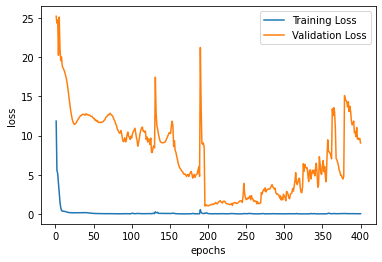

In [40]:
for epoch in range(start_epoch, start_epoch + num_epoch):
    train(epoch)
    test(epoch)


elapsed_time = time.time() - start_time
print(elapsed_time)


plt.figure(1)
plt.plot(range(1, num_epoch+1), history['training_loss'], label='Training Loss')
plt.plot(range(1, num_epoch+1), history['test_loss'], label='Validation Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

if not os.path.isdir(log_dir):
    os.mkdir(log_dir)
pkl.dump(history, open(log_dir+'/history.pkl', 'wb'))


if not os.path.isdir(ckpt_dir):
    os.mkdir(ckpt_dir)
torch.save(state, './%s/%s.pth' % (ckpt_dir, experiment_name))


plt.show()

In [41]:
def evaluate(test_loader, batch_size, n_features, model):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    with torch.no_grad():
        predictions = []
        values = []
        for x_test, y_test in test_loader:
            x_test = x_test.view([batch_size, -1, n_features]).to(device)
            y_test = y_test.to(device)
            model.eval()
            yhat = model(x_test)
            #batch_pred = []
            #for i in range(batch_size):
            #    batch_y_hat = yhat[i].detach().numpy()
            #    batch_pred.append(batch_y_hat[-1][-1])
            #batch_pred = array(batch_pred)
            yhat = torch.flatten(yhat).detach().numpy()
            
            predictions.append(yhat)
            values.append(y_test.to(device).detach().numpy())
        #print(yhat.item())
        #print('Len pred:/n', len(predictions))
        #print('Len vals:/n', len(values))
    return predictions, values

In [42]:
predictions, values =  evaluate(test_loader_one, batch_size=1, n_features=input_dim, model=model)

In [ ]:
array(predictions)

In [ ]:
values

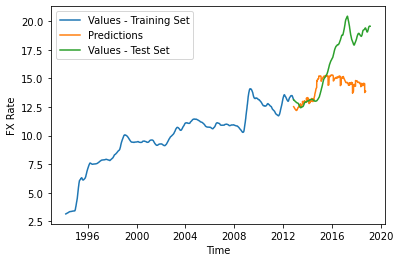

In [43]:
plt.figure(1)
plt.plot(X_train.index, X_train.iloc[:,0], label='Values - Training Set')
plt.plot(X_test.index[0:len(predictions)], array(predictions), label='Predictions')
plt.plot(X_test.index, X_test.iloc[:,0], label='Values - Test Set')

plt.xlabel('Time')
plt.ylabel('FX Rate')
plt.legend()

In [ ]:
def inverse_transform(scaler, df, columns):
    for col in columns:
        df[col] = scaler.inverse_transform(df[col])
    return df

def format_predictions(predictions, values, df_test, scaler):
    vals = np.concatenate(values, axis=0).ravel()
    preds = np.concatenate(predictions, axis=0).ravel()
    df_result = pd.DataFrame(data={"value": vals, "prediction": preds}, index=df_test.head(len(vals)).index)
    df_result = df_result.sort_index()
    df_result["prediction"] = inverse_transform(scaler, df_result, [["prediction"]])
    return df_result

In [ ]:
df_result = format_predictions(predictions, values, X_test, scaler)
df_result 

In [ ]:
plt.figure(1)
plt.plot(df_result.index, df_result['value'], label='Values - Test Set')
plt.plot(df_result.index, df_result['prediction'], label='Prediction - vs Test set')
plt.plot(X_val.index, X_val.iloc[:,0], label='Values - Validation Set')
plt.plot(X_train.index, X_train.iloc[:,0], label='Values - Training Set')
plt.xlabel('Time')
plt.ylabel('FX Rate (Domestic Currency vs US Dollar)')
plt.legend()

In [ ]:
plt.figure(1)
plt.plot(df_result.index, df_result['value'], label='Values - Test Set')
plt.plot(df_result.index, df_result['prediction'], label='Prediction - vs Test set')
plt.xlabel('Time')
plt.ylabel('FX Rate (Domestic Currency vs US Dollar)')
plt.legend()

In [ ]:
predictions_full, values_full = evaluate(test_loader, batch_size=batch_size, n_features=input_dim, model=model)

In [ ]:
df_result_full = format_predictions(predictions_full, values_full, X_test, scaler)
df_result_full
plt.figure(1)
plt.plot(df_result_full.index, df_result_full['value'], label='Values - Test Set')
plt.plot(df_result_full.index, df_result_full['prediction'], label='Prediction - vs Test set')
plt.plot(X_val.index, X_val.iloc[:,0], label='Values - Validation Set')
plt.plot(X_train.index, X_train.iloc[:,0], label='Values - Training Set')
plt.xlabel('FX Rate')
plt.ylabel('Time')
plt.legend()

In [ ]:
df_result_full.head(60)

## Investigation 

In [ ]:
#==========================================
## TESTING EVALUATION / OUTPUT OF THE MODEL
#==========================================
input_dim = len(X_train.columns) #sequence length
output_dim = 1
seq_length = 300
hidden_dim = 64
layer_dim = 5
batch_size = 64
dropout = 0.2
n_epochs = 100
#learning_rate = 1e-3
weight_decay = 1e-6

model_params = {'input_dim': input_dim,
                'hidden_dim' : hidden_dim,
                'seq_length' : seq_length,
                'layer_dim' : layer_dim,
                'output_dim' : output_dim,
                'dropout_prob' : dropout}

#Create NN
loss_fn = nn.MSELoss(reduction="mean")
#Set up model 
LSTM_Mod = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)


#print('Input - Train Loader:',train.shape)
for batch_idx, (inputs, targets) in enumerate(train_loader):
    if batch_idx == 1:
        break    
    print('________BATCH #',batch_idx,'_________________')
    print(' - - - - - -  Inputs - - - - - - - - ')
    print(' - - - - - - Inputs size: - - - - - - \n',inputs.size())
    print(' - - - - - - targets size: - - - - - - \n',targets.size())    
    adjusted_input = inputs.view([batch_size, -1, input_dim]).to(device)
    
    
Test_hidden_state = torch.randn(layer_dim, batch_size, hidden_dim)
Test_cell_state = torch.randn(layer_dim, batch_size, hidden_dim)
test_hidden = (Test_hidden_state,Test_cell_state)

print('Test_hidden_state shape :',Test_hidden_state.shape)
print('Test_cell_state shape :',Test_cell_state.shape)
print('test_hidden shape :',test_hidden[0].shape,test_hidden[1].shape)
fc = nn.Linear(hidden_dim, output_dim)
out, test_hidden = LSTM_Mod(adjusted_input, test_hidden)
print("Output shape: ", out.squeeze()[-1, :].shape)
print("Output shape: ", out.squeeze()[:, -1, :])
#print("Hidden: ", test_hidden)

In [ ]:
#==========================================
## TESTING EVALUATION / OUTPUT OF THE MODEL DEF TRAIN
#==========================================

fn_acc_alt = lambda pred, label: (np.absolute(pred.detach().numpy()-label.detach().numpy())).mean()
net.train()
train_loss = []
acc_arr = []
for batch_idx, (inputs, targets) in enumerate(train_loader):
    if batch_idx == 1:
        break    
    print('________BATCH________',batch_idx,'_________')
    print(' - - - - - - - - - - - Inputs - - - - - - - - - - - ')
    print('Inputs size:',inputs.size())
    print('targets size:',targets.size())
    print('Adjusted Inputs:',inputs.view([batch_size, -1, input_dim]).size())
    
    print(' - - - - - - - - - - - outputs - - - - - - - - - - - ')
    inputs = inputs.view([batch_size, -1, input_dim]).to(device)
    targets = targets.to(device)
    optimizer.zero_grad()
    
    outputs = net(inputs)
    print('Outputs size:',outputs.size())
    #print('Outputs:',outputs)
    pred = fn_pred(outputs)
    #print('Predictions :',pred)
    print('Predictions SHAPE :',pred.shape)
    pred = torch.flatten(pred)
    print('flattened Predictions SHAPE :',pred.shape)
    loss = criterion(outputs, targets)
    print('Loss :',loss)
    
    #acc = fn_acc(pred, targets)
    acc_alt = fn_acc_alt(pred, targets)
    print('Alternative Accuracy :',acc_alt)
    #print('Alternative Accuracy :',acc)
    #print('Accuracy Breakdown :',(pred.max(dim=1)[1]).size())
    #print('Accuracy no [1] :',pred.max(dim=1))#[1])
    #print('Accuracy dim=-1 :',(pred.max(dim=-1)[1]).size())




In [ ]:
#==========================================
## TESTING TRAINING THE MODEL
#==========================================
# Defining inspeting net as to not interupt the main model 
net_test = net

In [ ]:
#==========================================
## TESTING TRAINING THE MODEL
#==========================================

fn_acc_alt = lambda pred, label: ((pred.max(dim=1)[0] == label).type(torch.float)).mean()
net_test.train()
train_loss = []
acc_arr = []
for batch_idx, (inputs, targets) in enumerate(train_loader):
    if batch_idx == 1:
        break    
    print('________BATCH #',batch_idx,'_________________')
    print(' - - - - - - - - - - - Inputs - - - - - - - - - - - ')
    print(' - - - - - - Inputs size: - - - - - - \n',inputs.size())
    print(' - - - - - - Inputs size(0): - - - - - - \n',inputs.size(0))
    print(' - - - - - - Inputs size(0): - - - - - - \n',inputs[0])
    print(' - - - - - - targets size: - - - - - - \n',targets.size())
    
    adjusted_input = inputs.view([batch_size, -1, input_dim]).to(device)
    print(' - - - - - - adjusted_input size: - - - - - - \n',adjusted_input.size())
    
    targets = targets.to(device)
    outputs = net(adjusted_input)
    print(' - - - - - - outputs size: - - - - - - \n',outputs.size())
    #print(' - - - - - - outputs: - - - - - - \n',outputs)


In [ ]:
#==========================================
## TESTING EVALUATION / OUTPUT OF THE MODEL
#==========================================
with torch.no_grad():
    Pr = []
    Va = []
    for batch_idx, (x_test, y_test) in enumerate(test_loader):
        if batch_idx ==1:
            break
        x_test = x_test.view([batch_size, -1, input_dim]).to(device)
        y_test = y_test.to(device)
        model.eval()
        yhat = model(x_test)
        print('xtest size:',x_test.size())
        print('ytest size:',y_test.size())
        print('yhat size:',yhat.size())
        print('________print values____________')
        print('--------xtest[0] - the first of 64 2D arrays :--------\n',x_test[0])
        print('--------ytest size--------:\n',y_test[0:10])
        print('--------yhat size:--------\n',yhat)
        

In [ ]:
# Copied - To prove this is suitable for multivariate
class Optimization:
    def __init__(self, model, loss_fn, optimizer):
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.train_losses = []
        self.val_losses = []
    
    def train_step(self, x, y):
        # Sets model to train mode
        self.model.train()

        # Makes predictions
        yhat = self.model(x)

        # Computes loss
        loss = self.loss_fn(y, yhat)

        # Computes gradients
        loss.backward()

        # Updates parameters and zeroes gradients
        self.optimizer.step()
        self.optimizer.zero_grad()

        # Returns the loss
        return loss.item()
    def train(self, train_loader, val_loader, batch_size=64, n_epochs=50, n_features=1):
        #model_path = f'models/{self.model}_{datetime.now().strftime("%Y-%m-%d %H:%M:%S")}'
        model_path = 'RNN_Test'
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        for epoch in range(1, n_epochs + 1):
            batch_losses = []
            for x_batch, y_batch in train_loader:
                x_batch = x_batch.view([batch_size, -1, n_features]).to(device)
                y_batch = y_batch.to(device)
                loss = self.train_step(x_batch, y_batch)
                batch_losses.append(loss)
            training_loss = np.mean(batch_losses)
            self.train_losses.append(training_loss)

            with torch.no_grad():
                batch_val_losses = []
                for x_val, y_val in val_loader:
                    x_val = x_val.view([batch_size, -1, n_features]).to(device)
                    y_val = y_val.to(device)
                    self.model.eval()
                    yhat = self.model(x_val)
                    val_loss = self.loss_fn(y_val, yhat).item()
                    batch_val_losses.append(val_loss)
                validation_loss = np.mean(batch_val_losses)
                self.val_losses.append(validation_loss)

            if (epoch <= 10) | (epoch % 50 == 0):
                print(
                    f"[{epoch}/{n_epochs}] Training loss: {training_loss:.4f}\t Validation loss: {validation_loss:.4f}"
                )

        torch.save(self.model.state_dict(), model_path)
    
    
    def evaluate(self, test_loader, batch_size=1, n_features=1):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        with torch.no_grad():
            predictions = []
            values = []
            for x_test, y_test in test_loader:
                x_test = x_test.view([batch_size, -1, n_features]).to(device)
                y_test = y_test.to(device)
                self.model.eval()
                yhat = self.model(x_test)
                predictions.append(yhat.to(device).detach().numpy())
                values.append(y_test.to(device).detach().numpy())

        return predictions, values
    def plot_losses(self):
        plt.plot(self.train_losses, label="Training loss")
        plt.plot(self.val_losses, label="Validation loss")
        plt.legend()
        plt.title("Losses")
        plt.show()
        plt.close()